# PROYECTO FINAL

La empresa GoGreen Bikesharing se dedica al alquiler de bicicletas y posee datos tales como la cantidad de bicis alquiladas por usuarios registrados, la cantidad de alquileres realizados por usuarios puntuales, y la cantidad total. 

A estos datos se les añadió información meteorológica y el calendario de festivos.

Ahora buscan analizar cuáles son los aspectos que más influyen en la cantidad de bicis que van a alquilar en un día.

In [164]:
# Tratamiento de datos
import numpy as np
import pandas as pd
#import sidetable as stb

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import sidetable as stb

# Asunciones y Preprocesamiento
from scipy import stats
import math
from scipy.stats import levene
#import researchpy as rp
from sklearn.preprocessing import StandardScaler
import itertools
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
import researchpy as rp # chi square

#Linear Regresion con Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = False

import pylab as py

In [165]:
df_bike = pd.read_csv("./EDA__parte_3.csv", index_col=0)
df_bike.sample(6)

,cnt,casual,registered,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed
14,1248,222,1026,1,0,1,15,0,6,0,2,9.6,49.9,10.583521
240,4634,729,3905,4,0,8,29,0,1,1,1,26.1,55.5,10.708275
164,4891,727,4164,3,0,6,14,0,2,1,1,24.8,50.7,18.041961
62,1944,214,1730,3,0,3,4,0,5,1,2,10.7,61.0,13.624182
669,5986,466,5520,1,1,11,1,0,4,1,2,15.0,58.2,10.542182
325,1607,69,1538,2,0,11,22,0,2,1,3,17.1,96.2,7.959064


---------

# <font color = orange> REGRESIÓN LINEAL MULTIPLE

### Este DF por ahora debe contener nuestra variable respuesta y todas las variables predictivas.

- Vamos a ver la variable respuesta grafico y comprobar la normalidad = 'cnt'
- Vamos a ver graficos de variables predictivas
- Correlacion
- Covarianza
- Vamos a ver si cumplen las asunciones para hacer Anova



    Este dataframe tiene variable respuesta, y las predictoras encoding como tipo objets y numericas que sin encoding.

In [166]:
df= df_bike.copy() # Voy a hacer una copia para no perder los datos por si necesita hacer OPCION 1

In [167]:
df.head()

,cnt,casual,registered,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,985,331,654,1,0,1,1,0,6,0,2,14.1,80.6,10.749882
1,801,131,670,1,0,1,2,0,0,0,2,14.9,69.6,16.652113
2,1349,120,1229,1,0,1,3,0,1,1,1,8.1,43.7,16.636703
3,1562,108,1454,3,0,1,4,0,2,1,1,8.2,59.0,10.739832
4,1600,82,1518,3,0,1,5,0,3,1,1,9.3,43.7,12.522300


    Se ha cambiado las que tienen encoding a "category"

In [170]:
df['season_encoding'] = df['season_encoding'].astype('category')  
df['yr'] = df['yr'].astype('category')  
df['mnth'] = df['mnth'].astype('category')  
df['day'] = df['day'].astype('category')  
df['holiday'] = df['holiday'].astype('category')  
df['weekday'] = df['weekday'].astype('category')  
df['workingday'] = df['workingday'].astype('category')  
df['weathersit'] = df['weathersit'].astype('category')  

### Variable respuesta - NORMALIDAD - SHAPIRO

    Nuestra variable respuesta es 'cnt', queremos ver cuantas reservas general según las variables predictoras.
    Parece que tenemos una distribución normal de nuestros datos.


| Test Shapiro  |  Resultado | Conclusión |
|---|---|---|
|  p-value > 0.05 | No significativo   | Datos  Normales|
|p-value < 0.05| Significativo| Datos No Normales |

ShapiroResult(statistic=0.9802490472793579, pvalue=2.313480784721378e-08)


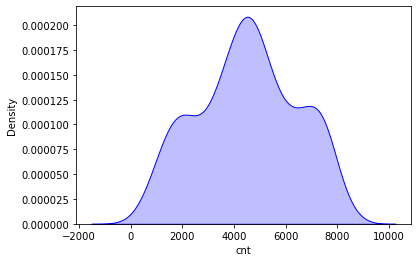

In [171]:
sns.distplot(
    df_bike.cnt, 
    hist = False, 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});

print(stats.shapiro(df_bike["cnt"])) # Los datos no son normales

    Intentamos normalizar los datos con boxcox, pero el resultado es el mismo, no se procede.

In [90]:
# df_bike['cnt'], lambda_ajustada = stats.boxcox(df_bike['cnt'])
# print(stats.shapiro(df_bike["cnt"]))

### Variables predictoras CATEGORICAS - GRAFICO

    Estas son nuestras variables categoricas

In [172]:
categoricas = df.select_dtypes(include='category')
categoricas.head(1)

,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit
0,1,0,1,1,0,6,0,2


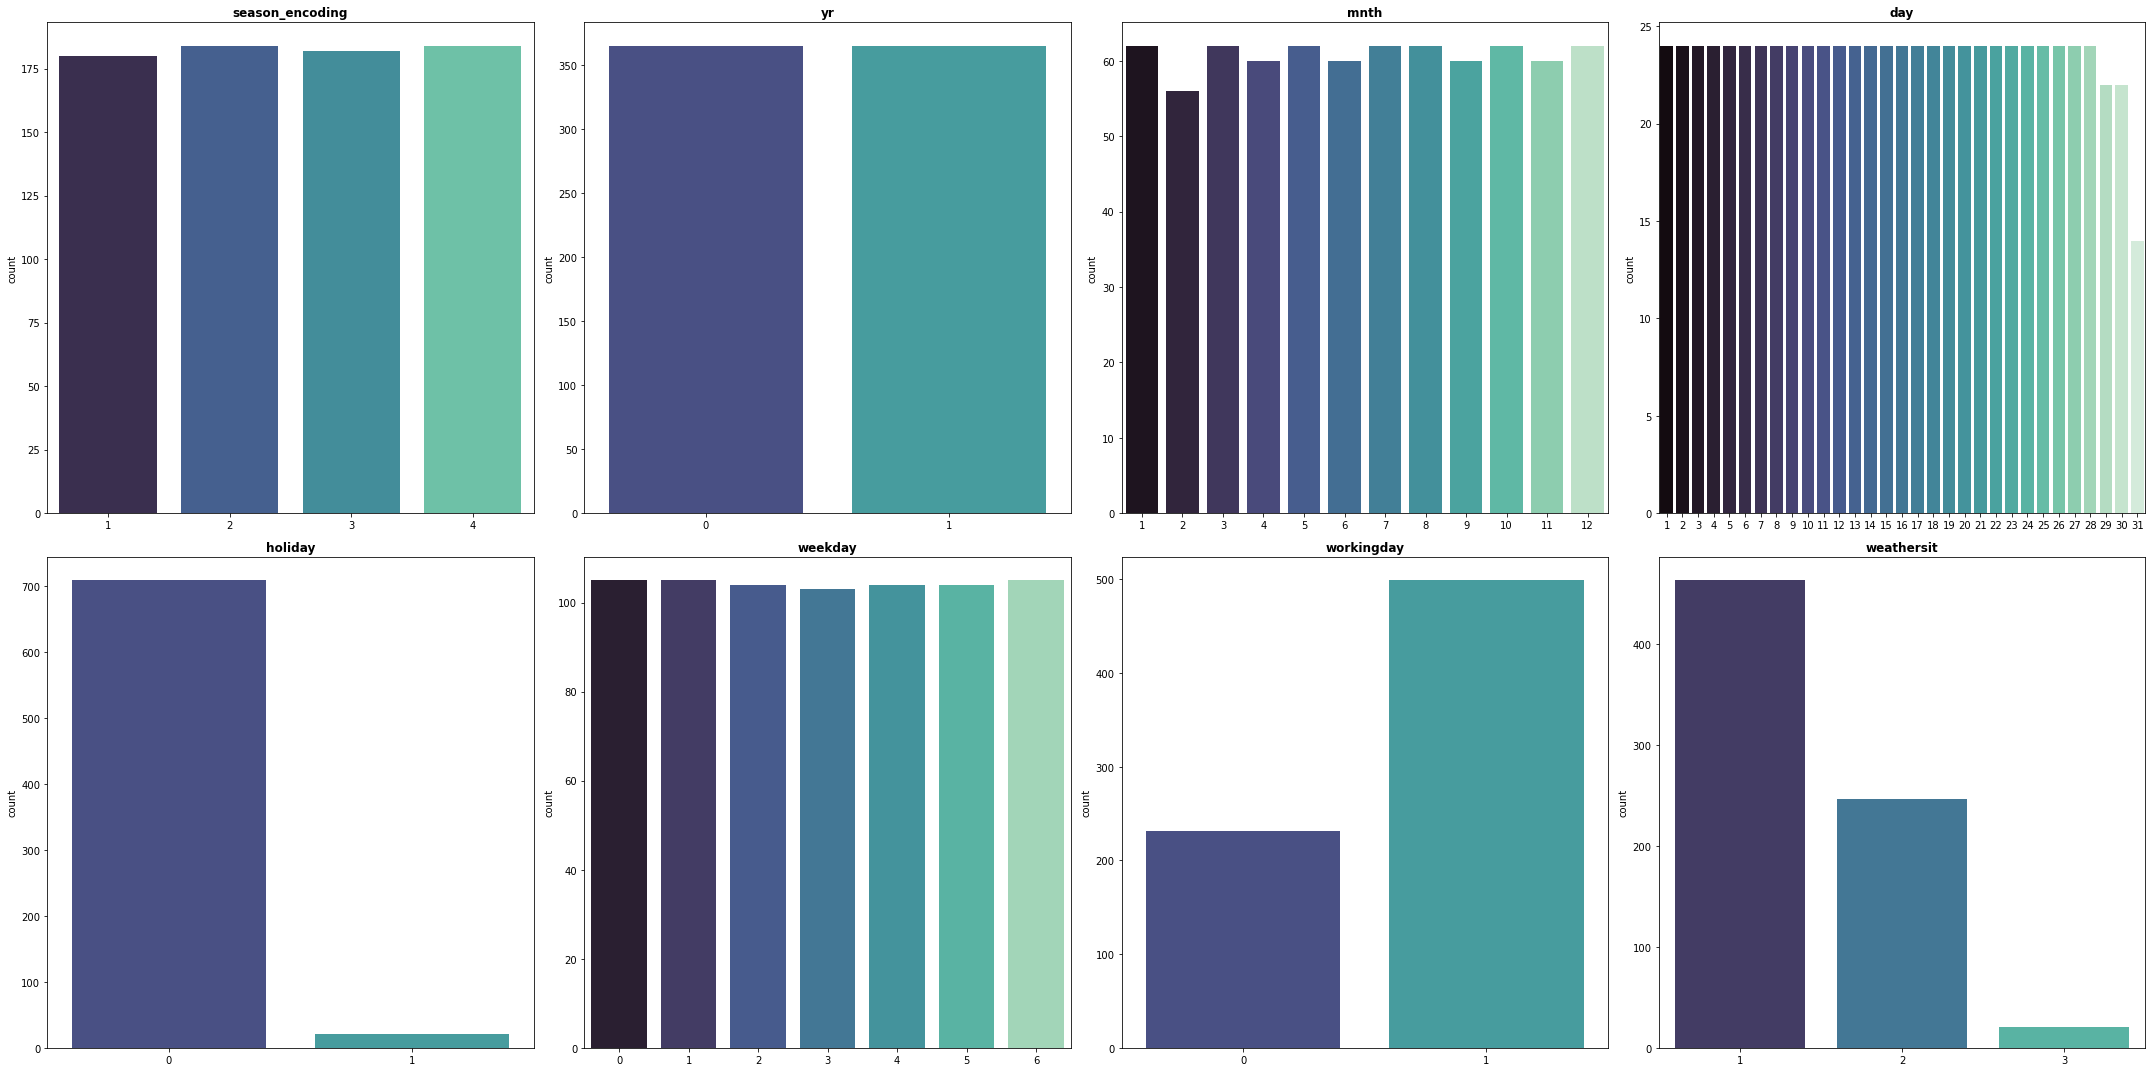

In [173]:
# Gráfico de relación entre variables predictoras y la variable a predecir CATEGORICAS
# ===================================================================================

fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (30, 15))

axes = axes.flat

columnas_object = df.select_dtypes(include = "category").columns

for i, colum in enumerate(columnas_object):
    sns.countplot(df[colum], ax=axes[i], palette="mako")
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")
    
fig.tight_layout();



### Variables predictoras NUMERICAS - GRAFICO

    Estas son nuestras variables numéricas

In [174]:
numericas = df.select_dtypes(include = np.number)
numericas.head(1)

,cnt,casual,registered,temp,hum,windspeed
0,985,331,654,14.1,80.6,10.749882


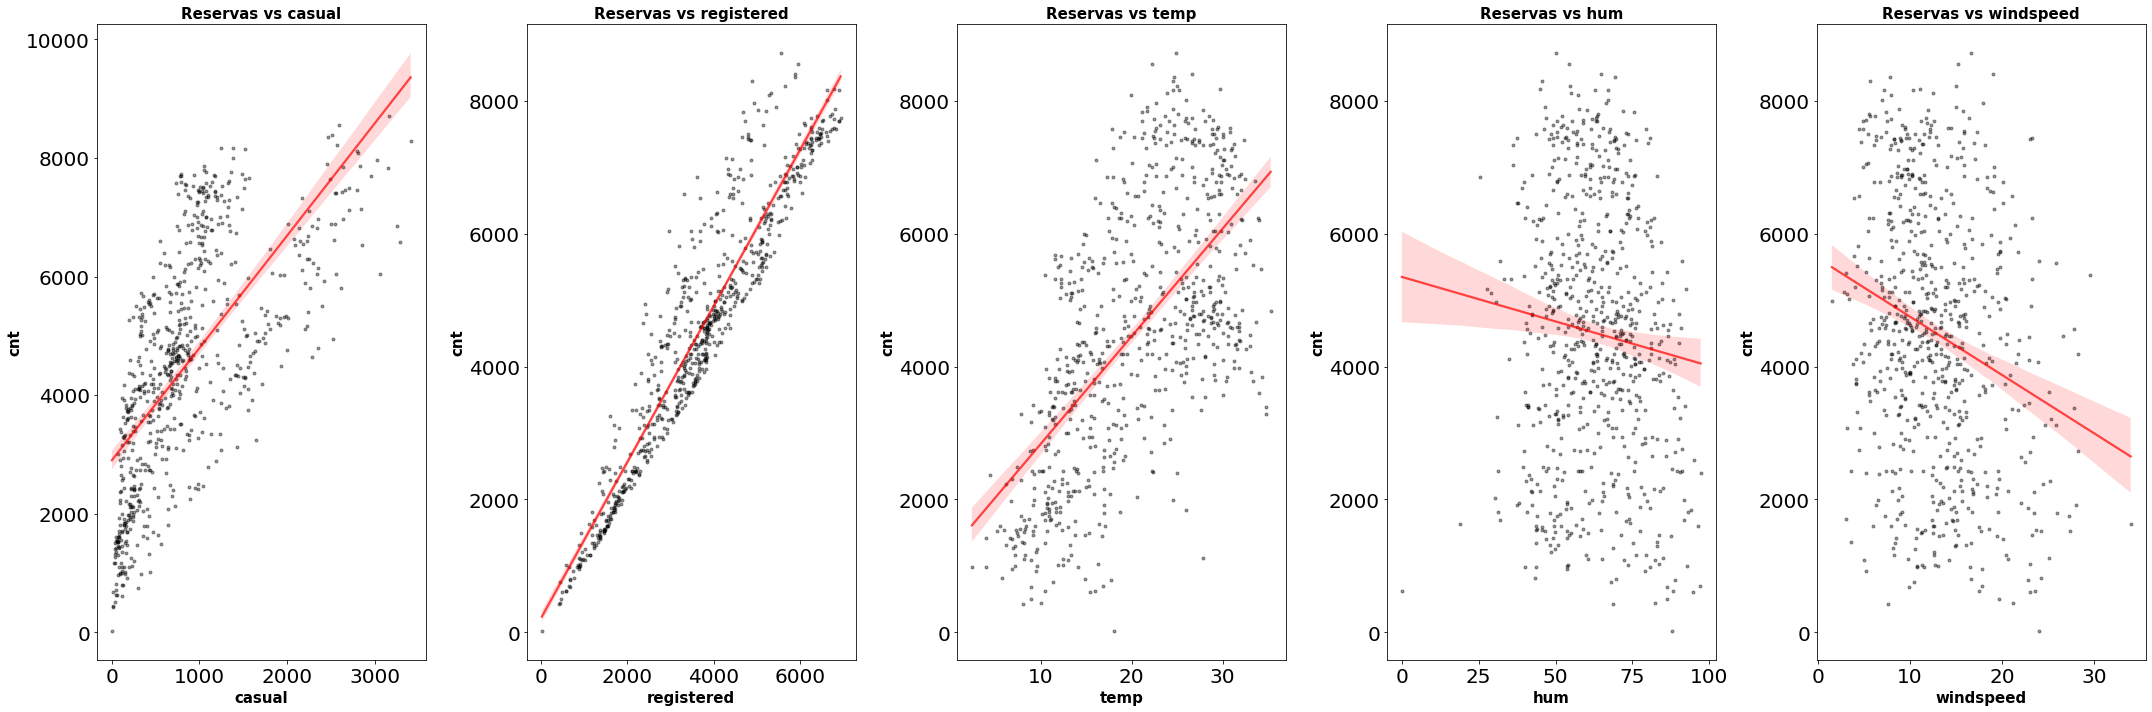

In [175]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================

fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (30, 10))

axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("cnt") # excluimos nuestra variable respuesta. (No la necesitamos ahora

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["cnt"], 
        color = "black", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Reservas vs {colum}", fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel(colum,  fontsize = 15, fontweight = "bold")
    axes[i].set_ylabel("cnt", fontsize = 15, fontweight = "bold")
    
fig.tight_layout();

### Vamos a comprobar la relación entre todas las variables

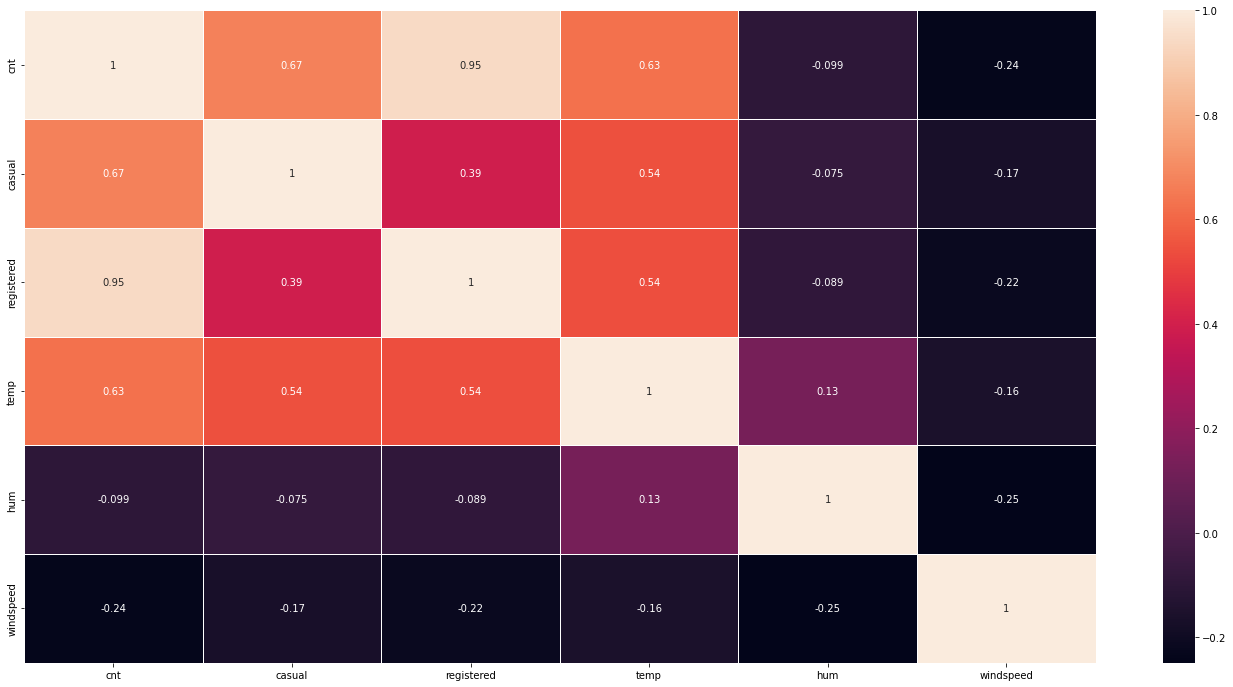

In [176]:
plt.figure(figsize = (24, 12))

corr = df.corr()
sns.heatmap(corr, annot = True, linewidths = 1)
plt.show()

    CORRELACIÓN
        Vamos a ver la correlación entre las variables predictoras y que relación tienen tb con la respuesta.
        intervalo [-1 y 1]
	    r= 1 corr perfecta positiva (aumenta una , la otra tb aumenta)
	    r =0 no hay correlación
 	    r= -1 corr perfecta negativa (una aumenta y la otra disminuye)

    Correlación con respecto a la columna "cnt"

In [177]:
correlation = df.corr()['cnt'].abs().sort_values(ascending = False) #correlación solo te enseña numéricas, Pearson RESPECTO A LA COLUMNA "cnt"
correlation

cnt           1.000000
registered    0.945411
casual        0.672123
temp          0.627003
windspeed     0.235132
hum           0.098502
Name: cnt, dtype: float64

    Correlación entre todas las numéricas

In [178]:
numericas.corr() 

,cnt,casual,registered,temp,hum,windspeed
cnt,1.000000,0.672123,0.945411,0.627003,-0.098502,-0.235132
casual,0.672123,1.000000,0.394137,0.542824,-0.075259,-0.167995
registered,0.945411,0.394137,1.000000,0.539345,-0.089140,-0.217914
temp,0.627003,0.542824,0.539345,1.000000,0.128716,-0.158367
hum,-0.098502,-0.075259,-0.089140,0.128716,1.000000,-0.248582
windspeed,-0.235132,-0.167995,-0.217914,-0.158367,-0.248582,1.000000


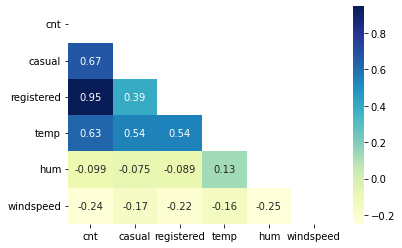

In [179]:
mask = np.triu(np.ones_like(numericas.corr(), dtype = np.bool))
sns.heatmap(numericas.corr(), 
           cmap = "YlGnBu", 
           annot = True, 
           mask =mask);


### Vamos a comprobar la relación que hay entre numericas

In [180]:
numericas2 = df.select_dtypes(include = np.number).drop("cnt", axis = 1)

    COVARIANZA
    ¿Ambas variables aumentan o disminuyen en la misma dirección o cuando una aumenta la otra disminuye?
        S> 0 COVARIANZA POSITIVA : Todos aumentan misma dirección ( a grandes valores de X, grandes valores de Y)
        S = 0 NO HAY RELACIÓN LINEAL
        S< 0 COVARIANZA NEGATIVA: Aumenta una y disminuye la otra (a grandes valores de X , pequeños valores de Y)

In [181]:
numericas2.cov() # vamos a ver si existe colinealidad entre mas medias de las variables predictoras

,casual,registered,temp,hum,windspeed
casual,471254.618141,4.220196e+05,2797.280226,-735.582158,-599.212506
registered,422019.595513,2.432847e+06,6314.994264,-1979.593043,-1766.034199
temp,2797.280226,6.314994e+03,56.350559,13.757125,-6.176868
hum,-735.582158,-1.979593e+03,13.757125,202.717828,-18.389602
windspeed,-599.212506,-1.766034e+03,-6.176868,-18.389602,26.996761


----

### Comprobar Outliers en este modelo

In [182]:
def detectar_outliers(lista_columnas, dataframe): 
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    return dicc_indices 

In [183]:
lista_columnas = list(numericas.columns)
lista_columnas

['cnt', 'casual', 'registered', 'temp', 'hum', 'windspeed']

     Son pocos Outliers que no influyen en demasiado lo cambiamos por la mediana

In [184]:
ind = detectar_outliers(lista_columnas, df)
print(ind)

{'casual': [148, 183, 184, 196, 246, 281, 440, 446, 454, 455, 461, 468, 469, 475, 489, 496, 503, 504, 510, 511, 512, 517, 518, 524, 531, 532, 538, 539, 549, 559, 567, 580, 594, 608, 609, 616, 622, 629, 630, 636, 643, 657, 664, 679], 'hum': [49, 68], 'windspeed': [44, 49, 93, 94, 292, 382, 407, 420, 431, 432, 449, 665, 720]}


In [185]:
for key, values in ind.items():
    median = df[key].median()
     
    if key == "hum" or key == 'windspeed':
        for i in values: 
            df.loc[i,key] = median
    else:
        pass

# Comprobación de las asunciones - Las variables predictoras deben cumplir: Homocedasteidad, Independencia 

### ASUNCIÓN DE NORMALIDAD  

    Ya la hemos comprobado y nuestros datos NO son normales.

- Visualmente
- Test de Shapiro


| Test Shapiro  |  Resultado | Conclusión |
|---|---|---|
|  p-value > 0.05 | No significativo   | Datos  Normales|
|p-value < 0.05| Significativo| Datos No Normales |

In [186]:
stats.shapiro(df["cnt"]) # El p-value< 0.05 Quiere decir que la distribución es No es NORMAL

ShapiroResult(statistic=0.9802490472793579, pvalue=2.313480784721378e-08)

### ASUNCIÓN DE HOMOCEDASTICIDAD (Levene)

Las varianzas no difieren entre las distintas categorías de nuestros datos


| Test Levene  |  Resultado | Conclusión   |
|---|---|---|
|  p-value > 0.05 | No significativo   | Cumple asunción, tienen varianzas similares|
|p-value < 0.05| Significativo| No cumple asunción, no tienen varianzas similares |

    - Variables Categoricas -

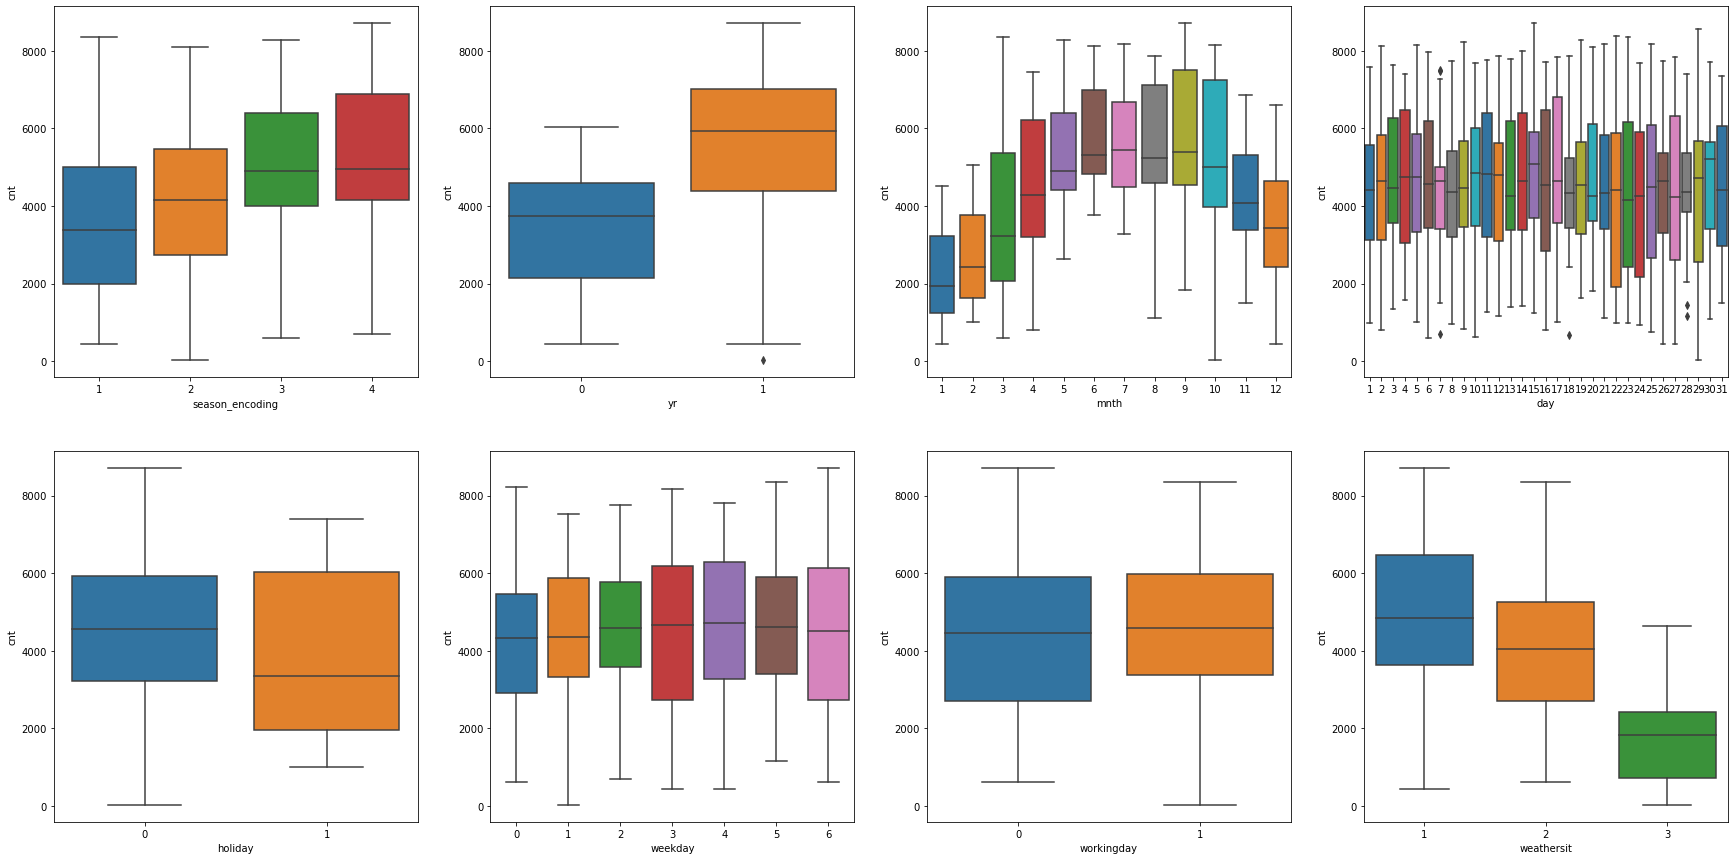

In [187]:
fig, axes = plt.subplots(nrows = 2, ncols = 4 ,figsize = (30, 15))

axes = axes.flat

colum_cat = df.select_dtypes(include = ['category']).columns

for i, col in enumerate(colum_cat):
    sns.boxplot(
        x = col,
        y = 'cnt',
        data = df,
        palette = 'tab10',
        ax = axes[i]

    )

                                                        --TEST LEVENE PARA CADA VARIABLE CATEGORICA PREDICTORA--

In [188]:
#Para desglosar cada una de las columnas, hacemos test de levene a cada una
def datos_test_levene (columna, df):
    valores = df[columna].unique()
    d = {}

    for x in valores:
        d['{0}'.format(x)] = df[df[columna] == x]['cnt']
    return d

In [189]:
# 8 variables categoricas predictoras
season = datos_test_levene('season_encoding', df)
year = datos_test_levene('yr', df)
month = datos_test_levene('mnth', df)
day = datos_test_levene('day', df)
holiday = datos_test_levene('holiday', df)
weekday =  datos_test_levene('weekday', df)
workingday = datos_test_levene('workingday', df)
weathersit = datos_test_levene('weathersit', df)

        --NO CUMPLEN--

In [190]:
levene_temp_interval = stats.levene(year['0'], year['1'], center='median')
levene_temp_interval # NO CUMPLE

LeveneResult(statistic=13.553593496753745, pvalue=0.0002489869491449798)

In [191]:
levene_workingday = stats.levene(workingday['0'], workingday['1'], center='median')
levene_workingday # NO CUMPLE

LeveneResult(statistic=4.460702577469021, pvalue=0.03502326959654844)

In [192]:
levene_month = stats.levene(month['1'], month['2'],month['3'],month['4'],month['5'],month['6'],month['1'],month['7'],month['1'],month['8'],month['9'],month['10'],month['11'],month['12'], center='median')
levene_month # NO CUMPLE

LeveneResult(statistic=5.787944098760116, pvalue=2.73789175494516e-10)

    ---SI CUMPLE---

In [193]:
levene_season = stats.levene(season['1'], season['2'], season['3'], season['4'], center='median')
levene_season # SI CUMPLE

LeveneResult(statistic=1.7590626071065214, pvalue=0.15360584747469838)

In [194]:
levene_day = stats.levene(day['1'], day['2'],day['3'],day['4'],day['5'],day['6'],day['1'],day['7'],day['1'],day['8'],day['9'],day['10'],day['11'],day['12'],
 day['13'], day['14'],day['15'],day['16'],day['17'],day['18'],day['19'],day['20'],day['21'],day['22'],day['23'],day['24'],day['25'],day['26'],
 day['27'], day['28'],day['29'],day['30'],day['31'],center='median')
levene_day # SI CUMPLE

LeveneResult(statistic=0.5456780499569595, pvalue=0.9815493458112784)

In [195]:
levene_holiday = stats.levene(holiday['0'], holiday['1'], center='median')
levene_holiday # SI CUMPLE

LeveneResult(statistic=0.7261499110317795, pvalue=0.39441424379573353)

In [196]:
levene_weekday = stats.levene(weekday['0'], weekday['1'],weekday['2'],weekday['3'],weekday['4'],weekday['5'],weekday['6'], center='median')
levene_weekday # SI CUMPLE

LeveneResult(statistic=1.496581827336433, pvalue=0.17647662349169893)

In [197]:
levene_weathersit = stats.levene(weathersit['1'], weathersit['2'], weathersit['3'],center='median')
levene_weathersit # SI CUMPLE

LeveneResult(statistic=2.981948873358019, pvalue=0.05131438057388725)

    Numéricas

In [198]:

# creamos un diccionario para almacenar los resultados de los test
resultados = {}

# seleccionamos solo las columnas numéricas y eliminamos la columna de precio
numericas_col = df.select_dtypes(include = np.number).drop("cnt", axis = 1).columns

#iteremos por la lista de las columnas numéricas
for col in numericas_col:
    # calculamos el p-valor de test
    statistic, p_val = levene(df[col], df.cnt, center='median')
    # lo almacenamos en el charges
    resultados[col] = p_val

                    --  NO CUMPLEN NINGUNA --

In [199]:
resultados 

{'casual': 3.031094721085453e-106,
 'registered': 3.756413456870291e-09,
 'temp': 2.483823693494982e-220,
 'hum': 2.4852444623529654e-219,
 'windspeed': 6.996761844872213e-221}

    Aplicamos log a las variables numéricas, para ver si podemos transformar y que alguna o todas puedan cumplir la asunción.  NO IMPLICA CAMBIO

In [119]:
#hemos intentado hacer logaritmonimos las variables categoricas .    NO nos funciona.

# df['casual'] = df['casual'].apply(lambda x: np.log(x) if x != 0 else 0)
# df['registered'] = df['registered'].apply(lambda x: np.log(x) if x != 0 else 0)
# df['temp'] = df['temp'].apply(lambda x: np.log(x) if x != 0 else 0)
# df['hum'] = df['hum'].apply(lambda x: np.log(x) if x != 0 else 0)
# df['windspeed'] = df['windspeed'].apply(lambda x: np.log(x) if x != 0 else 0)

    Aplicamos raiz cuadrada a las variables numéricas, para ver si podemos transformar y que alguna o todas puedan cumplir la asunción.

In [120]:
# df["temp"]= df["temp"].apply(lambda x: math.sqrt(x))
# df["hum"]= df["hum"].apply(lambda x: math.sqrt(x))
# df["windspeed"]= df["windspeed"].apply(lambda x: math.sqrt(x))

## Asunción independencia (Chi-Cuadrado)


| Test Independencia |  Resultado | Conclusión   |
|---|---|---|
|  p-value > 0.05 | No significativo   | Cumple asunción, tienen varianzas similares|
|p-value < 0.05| Significativo| No cumple asunción, no tienen varianzas similares |

In [200]:
columnas = df.columns

In [201]:
combinaciones = list(itertools.combinations(columnas, 2))
combinaciones[13]

('casual', 'registered')

In [207]:
combinaciones = list(itertools.combinations(columnas, 2))
combinaciones_cnt= combinaciones[:13]#, combinaciones[1], combinaciones[13] # ya solo te muestra con respecto a "cnt"
combinaciones_cnt

[('cnt', 'casual'),
 ('cnt', 'registered'),
 ('cnt', 'season_encoding'),
 ('cnt', 'yr'),
 ('cnt', 'mnth'),
 ('cnt', 'day'),
 ('cnt', 'holiday'),
 ('cnt', 'weekday'),
 ('cnt', 'workingday'),
 ('cnt', 'weathersit'),
 ('cnt', 'temp'),
 ('cnt', 'hum'),
 ('cnt', 'windspeed')]

    Test Chi Cuadrado
    Kramer: 
    de 0-0,1: no hay independencia
    de 0,1 - 0,3 independencia baja
    0,3 a 0,5 independencia moderada
    0,5+ independencia alta


In [208]:
for par in combinaciones_cnt:
    crosstab, test_results, expected = rp.crosstab(df[par[0]], df[par[1]],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")
    print("---------------------------------", par[0], par[1], "---------------------------------")
    print(test_results) #todas son independientes

--------------------------------- cnt casual ---------------------------------
                     Chi-square test      results
0  Pearson Chi-square ( 419176.0) =   419506.6667
1                         p-value =        0.3588
2                      Cramer's V =        0.9754
--------------------------------- cnt registered ---------------------------------
                     Chi-square test      results
0  Pearson Chi-square ( 469838.0) =   470667.5000
1                         p-value =        0.1960
2                      Cramer's V =        0.9759
--------------------------------- cnt season_encoding ---------------------------------
                   Chi-square test    results
0  Pearson Chi-square ( 2082.0) =   2089.9375
1                       p-value =      0.4470
2                    Cramer's V =      0.9769
--------------------------------- cnt yr ---------------------------------
                  Chi-square test   results
0  Pearson Chi-square ( 694.0) =   706.0000
1  

    --Si son independientes--

# ANOVA

    Ya podemos pasar a la ANOVA después de comprobar si las variables predictoras cumplen las asunciones

In [209]:
df.columns

Index(['cnt', 'casual', 'registered', 'season_encoding', 'yr', 'mnth', 'day',
       'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum',
       'windspeed'],
      dtype='object')

    No añadimos "registered"

In [210]:
lm = ols('cnt ~  casual + season_encoding + yr + mnth + day + holiday + weekday + workingday + weathersit + temp + hum +  windspeed' , data=df).fit()
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
season_encoding,3.0,2.965983e+08,9.886610e+07,262.807410,9.232468e-113
yr,1.0,8.869095e+08,8.869095e+08,2357.596632,8.943830e-222
mnth,11.0,7.803896e+08,7.094451e+07,188.585804,6.726230e-197
day,30.0,6.263900e+07,2.087967e+06,5.550266,3.255271e-18
holiday,1.0,8.356054e+06,8.356054e+06,22.212193,2.969398e-06
weekday,6.0,1.555021e+07,2.591702e+06,6.889303,4.102127e-07
workingday,1.0,4.369330e+04,4.369330e+04,0.116146,7.333591e-01
weathersit,2.0,1.746155e+08,8.730774e+07,232.082804,2.471926e-77
casual,1.0,2.342303e+08,2.342303e+08,622.634597,9.979754e-98
temp,1.0,1.246548e+07,1.246548e+07,33.135944,1.307773e-08


In [211]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     113.7
Date:                Wed, 15 Jun 2022   Prob (F-statistic):          3.36e-307
Time:                        15:32:31   Log-Likelihood:                -5690.9
No. Observations:                 730   AIC:                         1.150e+04
Df Residuals:                     671   BIC:                         1.177e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              356.6242    237.055      1.504      0.133    -108.835     822.084
season_encoding[T.2]  -863.7501    134.176     -6.437      0.000   -1127.206    -600.294
season_encoding[T.3]  -112.2496    132.729     -0.846      0.398    -372.864     148.365
season_encoding[T.4]   170.1781    135.956      1.252      0.211     -96.772     437.128
yr[T.1]               1618.6137     50.344     32.151      0.000    1519.764    1717.464
mnth[T.2]              167.1802    115.594      1.446      0.149     -59.789     394.150
mnth[T.3]              357.7042    124.355      2.876      0.004     113.532     601.877
mnth[T.4]              725.6083    162.872      4.455      0.000     405.808    1045.409
mnth[T.5]              965.1883    183.955      5.247      0.000     603.991    1326.385
mnth[T.6]              984.5038    206.093      4.777      0.000     579.838    1389.169
mnth[T.7]              475.4431    238.019      1.998      0.046       8.091     942.795
mnth[T.8]              763.8200    224.378      3.404      0.001     323.253    1204.387
mnth[T.9]             1328.8584    201.801      6.585      0.000     932.620    1725.097
mnth[T.10]            2000.1314    171.104     11.690      0.000    1664.168    2336.095
mnth[T.11]            1695.6418    150.259     11.285      0.000    1400.608    1990.676
mnth[T.12]            1394.2986    144.184      9.670      0.000    1111.193    1677.405
day[T.2]                74.7387    177.810      0.420      0.674    -274.393     423.870
day[T.3]                93.2341    178.114      0.523      0.601    -256.495     442.963
day[T.4]               199.8793    223.082      0.896      0.371    -238.143     637.902
day[T.5]               230.2166    222.135      1.036      0.300    -205.947     666.380
day[T.6]               264.3795    222.928      1.186      0.236    -173.341     702.100
day[T.7]              -187.9049    224.193     -0.838      0.402    -628.108     252.299
day[T.8]              -150.6411    223.709     -0.673      0.501    -589.896     288.614
day[T.9]              -108.5017    223.168     -0.486      0.627    -546.693     329.690
day[T.10]             1045.1206    223.163      4.683      0.000     606.938    1483.303
day[T.11]             1117.8522    222.726      5.019      0.000     680.528    1555.176
day[T.12]             1054.7443    223.202      4.726      0.000     616.485    1493.003
day[T.13]              304.5042    196.799      1.547      0.122     -81.911     690.919
day[T.14]              268.5003    196.151      1.369      0.172    -116.644     653.645
day[T.15]              442.4931    196.707      2.250      0.025      56.258     828.728
day[T.16]              495.4151    196.838      2.517      0.012     108.922     881.908
day[T.17]              498.9497    197.102      2.531    

# VIF - Para comprobar si hay o no multicolinealidad (Correlación alta entre dos v. predictoras), podemos averiguar si eliminar o no ésta variable.

Vif = 1 No existe corr entre una variable predictora y el resto

Vif = 1-5 Correlación moderada

Vif= +5 Correlación severa (Puede que se deba eliminar esa variable)

In [212]:
def get_VIF(dataframe, target):
        X = add_constant(dataframe.loc[:, dataframe.columns != target])
        seriesObject = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])] , index=X.columns,).sort_values(ascending= False)
        return seriesObject

In [213]:
get_VIF(df,'cnt')

const              57.356721
registered          5.250707
casual              3.499982
workingday          3.049152
temp                2.692000
yr                  2.505302
hum                 2.022413
weathersit          1.999211
mnth                1.344211
season_encoding     1.326242
windspeed           1.177274
holiday             1.099122
weekday             1.041472
day                 1.019574
dtype: float64

In [214]:
get_VIF(df.drop(columns=['registered','casual']),'cnt')

const              52.810975
hum                 1.999244
weathersit          1.859346
temp                1.377595
season_encoding     1.322259
mnth                1.137880
windspeed           1.134465
holiday             1.083125
workingday          1.076342
yr                  1.027614
weekday             1.019686
day                 1.011929
dtype: float64

# Regresion Lineal

In [215]:
df_standardized = df.copy()

In [216]:
numericas2 = df_standardized.select_dtypes(include = np.number)

In [217]:
st = MinMaxScaler()
x_tranformadas = pd.DataFrame(st.fit_transform(numericas2))
x_tranformadas.columns = numericas2.columns
df[x_tranformadas.columns] = x_tranformadas
df.head()

,cnt,casual,registered,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,0.110792,0.096538,0.091539,1,0,1,1,0,6,0,2,0.355623,0.768802,0.388102
1,0.089623,0.037852,0.093849,1,0,1,2,0,0,0,2,0.379939,0.615599,0.635752
2,0.152669,0.034624,0.174560,1,0,1,3,0,1,1,1,0.173252,0.254875,0.635105
3,0.177174,0.031103,0.207046,3,0,1,4,0,2,1,1,0.176292,0.467967,0.387681
4,0.181546,0.023474,0.216286,3,0,1,5,0,3,1,1,0.209726,0.254875,0.462471


In [218]:
x2 = df_standardized.drop(['cnt','registered','casual'] ,axis =1)
y2 = df_standardized['cnt']

In [219]:
X_train, X_test, y_train, y_test = train_test_split(x2, y2, train_size   = 0.8, random_state = 42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [220]:
def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

In [221]:
results = metricas(y_test, y_train, y_pred_test, y_pred_train)
results.style.background_gradient(cmap='coolwarm')
results

,MAE,MSE,RMSE,R2,set
0,619.579992,654509.631993,809.017696,0.808782,test
1,712.627673,898627.461256,947.959631,0.764492,train


In [223]:
print('Este es el % de error entre los conjuntos de datos entrenado y test', (100 - results['RMSE'][0]* 100 / results['RMSE'][1]).round(2),'%')

print('El', (100 * results['R2'][1]).round(2), '% de la variación de nuestros datos están explicados con este modelo, según las variables que hemos tenido en cuenta')

print('No es capaz de explicar el', (1 - results['R2'][1]).round(2)*100,'%')

Este es el % de error entre los conjuntos de datos entrenado y test 14.66 %
El 76.45 % de la variación de nuestros datos están explicados con este modelo, según las variables que hemos tenido en cuenta
No es capaz de explicar el 24.0 %


    El error cuadrático medio (RMSE) mide la cantidad de error que hay entre dos conjuntos de datos.

    El R-cuadrado es una medida estadística de qué tan cerca están los datos de la línea de regresión ajustada. 
    El R-cuadrado siempre está entre 0 y 100%:
    0% indica que el modelo no explica ninguna porción de la variabilidad de los datos de respuesta en torno a su media.
    100% indica que el modelo explica toda la variabilidad de los datos de respuesta en torno a su media.

----

    Residuos son valores reales frente a los predichos: valor real menos valor predicho

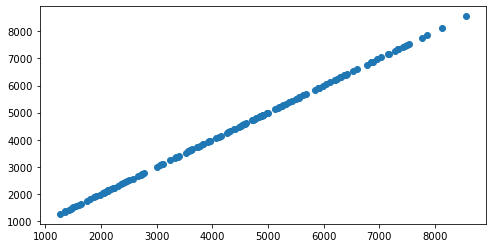

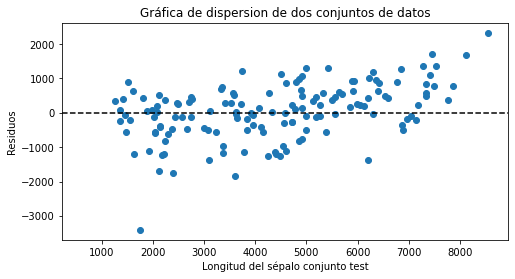

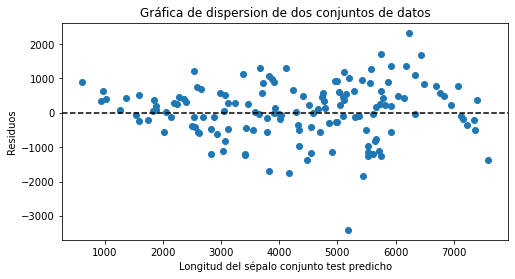

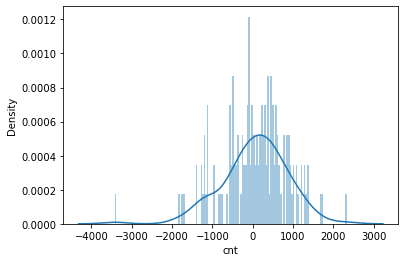

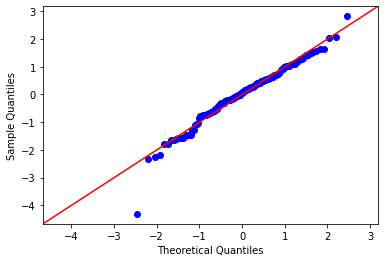

In [224]:
# Aquí comienza la resolucion del ejercicio 1
residuals = (y_test - y_pred_test)

# 1. Linealidad

plt.figure(figsize =(8,4))
plt.scatter(x=y_test , y=y_test)
plt.show()

# 2. Independencia

fig,ax = plt.subplots(figsize= (8,4))
plt.scatter(x=y_test , y=residuals)
plt.axline((float(min(y_pred_test)),0),(float(max(y_pred_test)),0),color="black",linestyle= '--') 
plt.title('Gráfica de dispersion de dos conjuntos de datos')
ax.set_xlabel('Longitud del sépalo conjunto test')
ax.set_ylabel('Residuos')
plt.show()

# 3. Homocedasticidad

fig,ax = plt.subplots(figsize= (8,4))
plt.scatter(x=y_pred_test , y=residuals)
plt.axline((float(min(y_pred_test)),0),(float(max(y_pred_test)),0),color="black",linestyle= '--') 
plt.title('Gráfica de dispersion de dos conjuntos de datos')
ax.set_xlabel('Longitud del sépalo conjunto test predicho')
ax.set_ylabel('Residuos')
plt.show()

# 4. Normalidad
# preprocessing.normalize()
fig = plt.figure()
sns.distplot(residuals,bins = len(residuals))
plt.show()
sm.qqplot(residuals, line = '45', fit = True)
py.show()

-----

In [225]:
train_df = pd.DataFrame({'Real': y_train, 'Predicted': y_pred_train, 'Set': ['Train']*len(y_train)})
test_df  = pd.DataFrame({'Real': y_test,  'Predicted': y_pred_test,  'Set': ['Test']*len(y_test)})
results = pd.concat([train_df,test_df], axis = 0)
results.head()

,Real,Predicted,Set
247,3351,3391.394525,Train
335,3940,3763.334601,Train
702,6606,6195.833033,Train
440,7836,5021.313705,Train
136,4123,2914.788515,Train


In [226]:
results['residual'] = results['Real'] - results['Predicted']

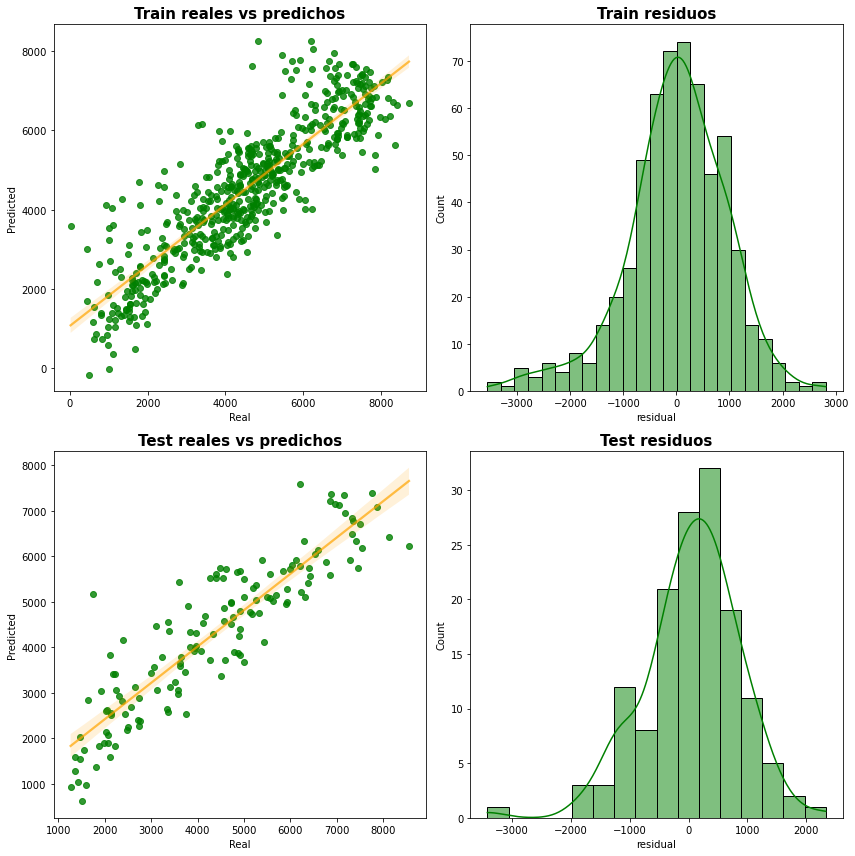

In [233]:
fig, ax = plt.subplots(2,2,figsize=(12,12))


# ploteamos los reales vs los predichos
sns.regplot(data = results[results['Set'] == "Train"], 
            x = "Real", 
            y = "Predicted", 
            ax = ax[0,0], 
            color = "green",
            line_kws = {"color": "orange", "alpha": 0.7 })


sns.regplot(data = results[results['Set'] == "Test"], 
            x = "Real",
            y = "Predicted", 
            color = "green",
            line_kws = {"color": "orange", "alpha": 0.7 }, 
            ax = ax[1,0])


# ploteamos los residuos
sns.histplot(results[results['Set'] == "Train"],
             x="residual",
             color ="green",
             kde=True, 
             ax = ax[0,1])


sns.histplot(results[results['Set'] == "Test"],
             x="residual",
             color = "green",
             kde=True, 
             ax = ax[1,1])

ax[0,0].set_title("Train reales vs predichos", fontsize = 15, fontweight = "bold")
ax[0,1].set_title("Train residuos", fontsize = 15, fontweight = "bold")
ax[1,0].set_title("Test reales vs predichos", fontsize = 15, fontweight = "bold")
ax[1,1].set_title("Test residuos", fontsize = 15, fontweight = "bold")

fig.tight_layout();

 ### Leyenda

 casual: nº de reservas

 season_encoing : 1- Winter   2- Spring   3- Summer    4-  Auttumn

 yr : random

 month: 1- Enero   2- Febrero  3- Marzo   4- Abril  5- Mayo   6 -Junio   7 - Julio  8- Agosto  9- Septiembre  10- OCtubre  11- Noviembre  12- Diciembre

 day: del 1 al 31

 holiday: 0- NO FESTIVO     1- FESTIVO

 weekday: 0 Domingo - 6 Sábado

 workingday: 1-laborable  0-fin de semana

 weathersit: 
 
 	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy

	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

 temp: grados

 hum: en % (gramo/metro cúbico)
 
 windspeed:km/h

    Preguntas generales:

    1- Cuantas reservas tendré en las dos próximas semanas, es Junio y en Madrid va hacer mucha calor, una ola de calor.

In [234]:
#DF Viernes 17 al Sábado 2 de Julio

df_quince_dias= pd.DataFrame({
'season_encoding':[3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
'yr':[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
'mnth':[7,7,7,7,7,7,7,7,7,7,7,7,7,8,8],
'day':[18,19,20,21,22,23,24,25,26,27,28,29,30,1,2],
'holiday':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
'weekday':[5,6,0,1,2,3,4,5,6,0,1,2,3,4,5],
'workingday':[0,0,1,1,1,1,1,0,0,1,1,1,1,1,0],
'weathersit':[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
'temp':[37,33,30,33,33,31,32,34,37,38,38,39,38,36,33],
'hum':[47,53,58,60,63,70,73,75,77,78,79,80,81,82,83],
'windspeed':[9,9,9,9,10,10,11,10,10,7,8,8,10,10,12]})


In [235]:
df_quince_dias['season_encoding'] = df_quince_dias['season_encoding'].astype('category')  
df_quince_dias['yr'] = df_quince_dias['yr'].astype('category')  
df_quince_dias['mnth'] = df_quince_dias['mnth'].astype('category')  
df_quince_dias['day'] = df_quince_dias['day'].astype('category') 
df_quince_dias['holiday'] = df_quince_dias['holiday'].astype('category')  
df_quince_dias['weekday'] = df_quince_dias['weekday'].astype('category')  
df_quince_dias['workingday'] = df_quince_dias['workingday'].astype('category')   
df_quince_dias['weathersit'] = df_quince_dias['weathersit'].astype('category')  

In [236]:
numericas_d=df_quince_dias.select_dtypes(include=np.number)

In [237]:
st = MinMaxScaler()
x_tranformadas = pd.DataFrame(st.fit_transform(numericas_d))
x_tranformadas.columns = numericas_d.columns
df_quince_dias[x_tranformadas.columns] = x_tranformadas
df_quince_dias.head(2)

,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,3,1,7,18,0,5,0,1,0.777778,0.000000,0.4
1,3,1,7,19,0,6,0,1,0.333333,0.166667,0.4


In [238]:
print('El total de alquiler de bicicletas durante esos 15, será de ',lr.predict(df_quince_dias).sum().astype('int64'),' bicicletas')
print('Estos 15 dias del 17 de Junio al 2 de Julio representan 2,99% del alquiler anual ')
print('La media de alquiler se encuentra en 4.508 en 2019, en estas fechas el numero de reservas es menor a la media diaria (4.091 al día)')

El total de alquiler de bicicletas durante esos 15, será de  62249  bicicletas
Estos 15 dias del 17 de Junio al 2 de Julio representan 2,99% del alquiler anual 
La media de alquiler se encuentra en 4.508 en 2019, en estas fechas el numero de reservas es menor a la media diaria (4.091 al día)


    Cuantas reservas una semana en Enero, el cliente quiere ir de vacaciones en esta fecha del 1 al 7

In [239]:
df_enero= pd.DataFrame({
'season_encoding':[1,1,1,1,1,1,1],
'yr':[1,1,1,1,1,1,1],
'mnth':[1,1,1,1,1,1,1],
'day':[1,2,3,4,5,6,7],
'holiday':[1,0,0,0,0,1,0],
'weekday':[0,1,2,3,4,5,6],
'workingday':[0,1,1,1,1,1,0],
'weathersit':[3,2,3,2,2,2,2],
'temp':[13.1,14.9,8,9.8,7.2,7.1,10],
'hum':[47,60,49.9,47,53.2,70.2,53.8],
'windspeed':[6,10.18,20.43,20.10,9.8,13,11.13]})

In [240]:
df_enero['season_encoding'] = df_enero['season_encoding'].astype('category')  
df_enero['yr'] = df_enero['yr'].astype('category')  
df_enero['mnth'] = df_enero['mnth'].astype('category')  
df_enero['day'] = df_enero['day'].astype('category') 
df_enero['holiday'] = df_enero['holiday'].astype('category')  
df_enero['weekday'] = df_enero['weekday'].astype('category')  
df_enero['workingday'] = df_enero['workingday'].astype('category')   
df_enero['weathersit'] = df_enero['weathersit'].astype('category')  

In [241]:
numericas_enero =df_enero.select_dtypes(include=np.number)

In [242]:
st = MinMaxScaler()
x_tranformadas = pd.DataFrame(st.fit_transform(numericas_enero))
x_tranformadas.columns = numericas_enero.columns
df_enero[x_tranformadas.columns] = x_tranformadas
df_enero.head(2)

,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,1,1,1,1,1,0,0,3,0.769231,0.000000,0.000000
1,1,1,1,2,0,1,1,2,1.000000,0.560345,0.289674


In [243]:
print('El total de alquiler de bicicletas durante la primera semana de Enero del 1 al 7 será de ',lr.predict(df_enero).sum().astype('int64'),' bicicletas')
print('Esta primera semana de Enero, temporda baja para el negocio, los datos obtenidos representan un  0,9º% del alquiler anual ')
print('La media de alquiler diaria en 2019 se encuentra en 4.508, en estas fechas el numero de reservas es menor a la media diaria (2.685 bicicletas al día)')

El total de alquiler de bicicletas durante la primera semana de Enero del 1 al 7 será de  18738  bicicletas
Esta primera semana de Enero, temporda baja para el negocio, los datos obtenidos representan un  0,9º% del alquiler anual 
La media de alquiler diaria en 2019 se encuentra en 4.508, en estas fechas el numero de reservas es menor a la media diaria (2.685 bicicletas al día)


---

### Ejemplo en Directo para el Cliente  👩🏼‍💻 

In [244]:
# Preparar los datos del  17 de junio al 2 de julio
dict_model = {"season_encoding":[2] ,'yr':[1], 'mnth':[6], 'day':[14] , 'holiday':[0], 'weekday':[4], 'workingday':[1], 'weathersit':[1], 'temp':[38], 'hum':[30], 'windspeed':[10]}
df_dict_model = pd.DataFrame(dict_model)
print('El día que el cliente ha elegido es el _ de ____')
print('Existe una previsión de alquiler total', lr.predict(df_dict_model) ,'bicicletas para este dia')#número de bicicletas que serán reservadas 

El día que el cliente ha elegido es el _ de ____
Existe una previsión de alquiler total [8663.7337927] bicicletas para este dia
